## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [10]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
x_train = x_train[:5000]
x_test = x_test[:5000]
y_train = y_train[:5000]
y_test = y_test[:5000]

In [14]:
# from tensorflow.keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.Dropout(drp_ratio)(x) ## dropout function has bug: https://github.com/tensorflow/tensorflow/issues/23410
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.1, 0.25, 0.5]

In [18]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for dropout_exp in Dropout_EXP:
    try:
        keras.backend.clear_session() # 把舊的 Graph 清掉
    except:
        pass
    print("Experiment with LR = %.6f" % (dropout_exp))
    model = build_mlp(input_shape=x_train.shape[1:],drp_ratio=dropout_exp)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
        
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-dropout-{dropout_exp}".format(dropout_exp=dropout_exp)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.100000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          

Epoch 42/50
5000/5000 [==============================] - 1s 164us/step - loss: 1.5600 - accuracy: 0.4340 - val_loss: 1.6755 - val_accuracy: 0.4028
Epoch 43/50
5000/5000 [==============================] - 1s 171us/step - loss: 1.5644 - accuracy: 0.4368 - val_loss: 1.6811 - val_accuracy: 0.3942
Epoch 44/50
5000/5000 [==============================] - 1s 166us/step - loss: 1.5439 - accuracy: 0.4420 - val_loss: 1.6752 - val_accuracy: 0.4002
Epoch 45/50
5000/5000 [==============================] - 1s 164us/step - loss: 1.5273 - accuracy: 0.4464 - val_loss: 1.6847 - val_accuracy: 0.3984
Epoch 46/50
5000/5000 [==============================] - 1s 166us/step - loss: 1.5711 - accuracy: 0.4274 - val_loss: 1.7019 - val_accuracy: 0.3938
Epoch 47/50
5000/5000 [==============================] - 1s 166us/step - loss: 1.5810 - accuracy: 0.4194 - val_loss: 1.6797 - val_accuracy: 0.3988
Epoch 48/50
5000/5000 [==============================] - 1s 167us/step - loss: 1.5699 - accuracy: 0.4286 - val_loss: 1

In [19]:
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())


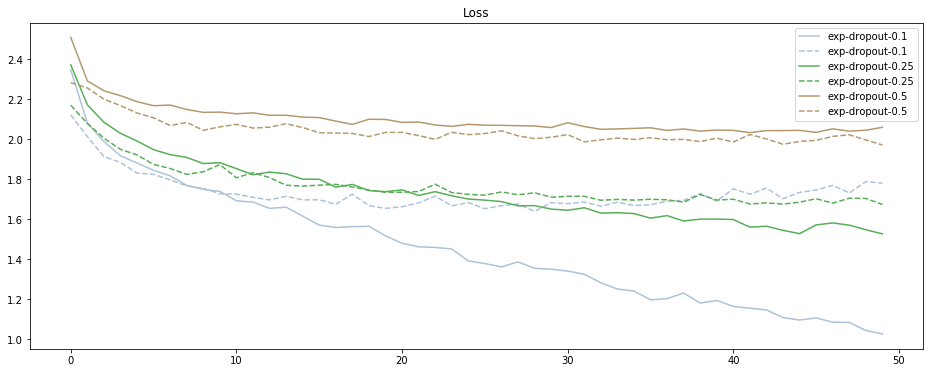

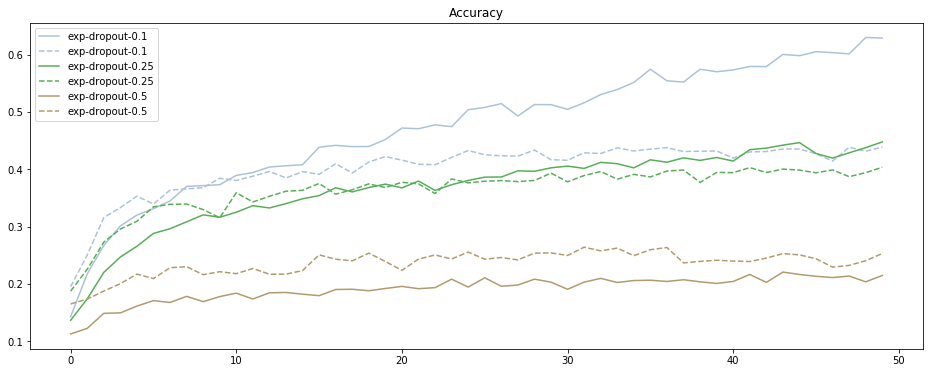

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = colors_list

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()